# Import Libraries

In [1]:
# General
from itertools import chain
from collections import Counter
from math import log

# Data manipulation
import numpy as np
import pandas as pd
import string
import re
import ast

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
from wordcloud import WordCloud
#from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase

# Natural langauge processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score

# Output Settings

In [2]:
# Set plot settings for later
plt.style.use('fivethirtyeight')
sns.set_palette('muted')

In [3]:
# Set font sizes for plots
plt.rc('font', size = 14)
plt.rc('axes', labelsize = 18)
plt.rc('legend', fontsize = 18)
plt.rc('axes', titlesize = 24)
plt.rc('figure', titlesize = 24)

# The Data

In [4]:
# Import data
stats = pd.read_csv('~/Documents/Winter 2022/STATS 201B/Final Project/data/resultstats.csv')
educ = pd.read_csv('~/Documents/Winter 2022/STATS 201B/Final Project/data/resulteducation.csv')
civeng = pd.read_csv('~/Documents/Winter 2022/STATS 201B/Final Project/data/resultcivileng.csv')
bio = pd.read_csv('~/Documents/Winter 2022/STATS 201B/Final Project/data/resultbiology.csv')

In [5]:
# Create column with class labels for each df (e.g. 'Stats')
stats['Category'] = stats['Journal'].apply(lambda x: 'Statistics')
civeng['Category'] = civeng['Journal'].apply(lambda x: 'Civil Engineering')
educ['Category'] = educ['Journal'].apply(lambda x: 'Education')
bio['Category'] = bio['Journal'].apply(lambda x: 'Biology')

In [6]:
# Combine the individual dfs into one
df = pd.concat([stats, educ, civeng, bio], ignore_index = True)[['Name', 'Category']]

# Rename column(s)
df = df.rename(columns = {'Name': 'Title'})

In [7]:
df.head()

,Title,Category
0,THE ANNALS,Statistics
1,On the adaptive elastic-net with a diverging n...,Statistics
2,One-step sparse estimates in nonconcave penali...,Statistics
3,High dimensional variable selection,Statistics
4,Strong oracle optimality of folded concave pen...,Statistics


In [8]:
df.describe()

,Title,Category
count,1917,1917
unique,1917,4
top,Variation and commonality in phenomenographic ...,Biology
freq,1,499


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     1917 non-null   object
 1   Category  1917 non-null   object
dtypes: object(2)
memory usage: 30.1+ KB


NOTE: may want to get rid of titles like "The Annals", etc. --> not sure if these refer to true research papers, could just be articles/documents found on the journal websites by the Python scraping script...

# Preprocessing: Text Cleaning

In [10]:
# Get only the titles to work with
titles = pd.DataFrame(df['Title'])
titles.head()

,Title
0,THE ANNALS
1,On the adaptive elastic-net with a diverging n...
2,One-step sparse estimates in nonconcave penali...
3,High dimensional variable selection
4,Strong oracle optimality of folded concave pen...


## Remove Noise from Text

Next, we want to change all uppercase letters to lowercase as well as get rid of a couple things that are not significant for modeling:
- punctuation
- numerical digits

In [11]:
# Make all characters lowercase and remove numbers + punctuation
def remove_noise(text):
    text_lc = ''.join([word.lower() for word in text if word not in string.punctuation])
    text = re.sub(r'\d+', '', text_lc)
    return text

In [12]:
titles['Title'] = titles['Title'].apply(lambda x: remove_noise(x))

In [13]:
titles.head()

,Title
0,the annals
1,on the adaptive elasticnet with a diverging nu...
2,onestep sparse estimates in nonconcave penaliz...
3,high dimensional variable selection
4,strong oracle optimality of folded concave pen...


## Tokenization

Tokenization refers to breaking a chunk/string of continuous text into a list of all of the words that appear in the string.

In [14]:
def tokenize(text):
    return re.split('\W+', text)

In [15]:
titles['Tokenized'] = titles['Title'].apply(lambda x: tokenize(remove_noise(x)))

We now have a new column in the data frame which contains an updated version of the text, converted to all lowercase with the numbers + punctuation taken out, then converted to a list of tokens, or words from the text.

## Remove Stopwords

Stopwords are very commonly used words such as "the", "in", "a", etc. that we want to exclude from our later analysis, so that they don't take up any unnecessary space and/or processing time. Now that we have tokenized the text, we can search for any stopwords and take them out. 

In [16]:
#nltk.download('stopwords')

In [17]:
stop_words = set(stopwords.words('english'))
stop_words.update(['im', 'let', 'us', 'области', '以工程认证和审核评估为契机'])    # TO DO: can add other words we don't want here

In [18]:
def remove_stopwords(text):    
    text_no_stopwords = [word for word in text if word not in stop_words]
    return text_no_stopwords

In [19]:
titles['No Stopwords'] = titles['Tokenized'].apply(lambda x: remove_stopwords(x))

## Lemmatization

TO DO: add explanation of lemmatization here!

In [20]:
#nltk.download('wordnet')

In [21]:
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text]

In [22]:
titles['Lemmatized'] = titles['No Stopwords'].apply(lambda x: lemmatize(x))

## Stemming

TO DO: add explanation of stemming here!

In [23]:
stemmer = nltk.PorterStemmer()

def stem(text):
    return [stemmer.stem(word) for word in text]

In [24]:
titles['Stemmed'] = titles['Lemmatized'].apply(lambda x: stem(x))

In [25]:
titles.head()

,Title,Tokenized,No Stopwords,Lemmatized,Stemmed
0,the annals,"[the, annals]",[annals],[annals],[annal]
1,on the adaptive elasticnet with a diverging nu...,"[on, the, adaptive, elasticnet, with, a, diver...","[adaptive, elasticnet, diverging, number, para...","[adaptive, elasticnet, diverging, number, para...","[adapt, elasticnet, diverg, number, paramet]"
2,onestep sparse estimates in nonconcave penaliz...,"[onestep, sparse, estimates, in, nonconcave, p...","[onestep, sparse, estimates, nonconcave, penal...","[onestep, sparse, estimate, nonconcave, penali...","[onestep, spars, estim, nonconcav, penal, like..."
3,high dimensional variable selection,"[high, dimensional, variable, selection]","[high, dimensional, variable, selection]","[high, dimensional, variable, selection]","[high, dimension, variabl, select]"
4,strong oracle optimality of folded concave pen...,"[strong, oracle, optimality, of, folded, conca...","[strong, oracle, optimality, folded, concave, ...","[strong, oracle, optimality, folded, concave, ...","[strong, oracl, optim, fold, concav, penal, es..."


In [26]:
# Now, we can add the new, lemmatized/stemmed text back to our original dataframe
df['Lemmatized'] = titles['Lemmatized']
df['Stemmed'] = titles['Stemmed']
df = df[['Title', 'Lemmatized', 'Stemmed', 'Category']]
df.head()

,Title,Lemmatized,Stemmed,Category
0,THE ANNALS,[annals],[annal],Statistics
1,On the adaptive elastic-net with a diverging n...,"[adaptive, elasticnet, diverging, number, para...","[adapt, elasticnet, diverg, number, paramet]",Statistics
2,One-step sparse estimates in nonconcave penali...,"[onestep, sparse, estimate, nonconcave, penali...","[onestep, spars, estim, nonconcav, penal, like...",Statistics
3,High dimensional variable selection,"[high, dimensional, variable, selection]","[high, dimension, variabl, select]",Statistics
4,Strong oracle optimality of folded concave pen...,"[strong, oracle, optimality, folded, concave, ...","[strong, oracl, optim, fold, concav, penal, es...",Statistics


# Exploratory Data Analysis

## Most Common Words

Now, let's try to compile the most common words used in the papers.

In [27]:
list_of_words = df['Lemmatized'].tolist()
all_words = [word for sublist in list_of_words for word in sublist]

In [28]:
# Separate df into multiple dfs by subject - mainly convenient for plotting
df_stats = df.loc[np.array(df['Category'] == 'Statistics'), :]
df_civeng = df.loc[np.array(df['Category'] == 'Civil Engineering'), :]
df_educ = df.loc[np.array(df['Category'] == 'Education'), :]
df_bio = df.loc[np.array(df['Category'] == 'Biology'), :]

In [29]:
# Get all words appearing in Stats
all_stats_words = [word for sublist in df_stats['Lemmatized'].tolist() for word in sublist]

# Civ Eng
all_civeng_words = [word for sublist in df_civeng['Lemmatized'].tolist() for word in sublist]

# Education
all_educ_words = [word for sublist in df_educ['Lemmatized'].tolist() for word in sublist]

# Biology
all_bio_words = [word for sublist in df_bio['Lemmatized'].tolist() for word in sublist]

In [30]:
#Frequency of stats words
words_dict = {k: v for k, v in sorted(dict(FreqDist(all_stats_words)).items(), key = lambda x: x[1], reverse = True)}
# Get the highest ranking words
stats_keys = list(words_dict)[:50]
stats_values = [words_dict[key] for key in list(words_dict)[:50]]

# Likewise for other categories...
words_dict = {k: v for k, v in sorted(dict(FreqDist(all_civeng_words)).items(), key = lambda x: x[1], reverse = True)}
civeng_keys = list(words_dict)[:50]
civeng_values = [words_dict[key] for key in list(words_dict)[:50]]

words_dict = {k: v for k, v in sorted(dict(FreqDist(all_educ_words)).items(), key = lambda x: x[1], reverse = True)}
educ_keys = list(words_dict)[:50]
educ_values = [words_dict[key] for key in list(words_dict)[:50]]

words_dict = {k: v for k, v in sorted(dict(FreqDist(all_bio_words)).items(), key = lambda x: x[1], reverse = True)}
bio_keys = list(words_dict)[:50]
bio_values = [words_dict[key] for key in list(words_dict)[:50]]

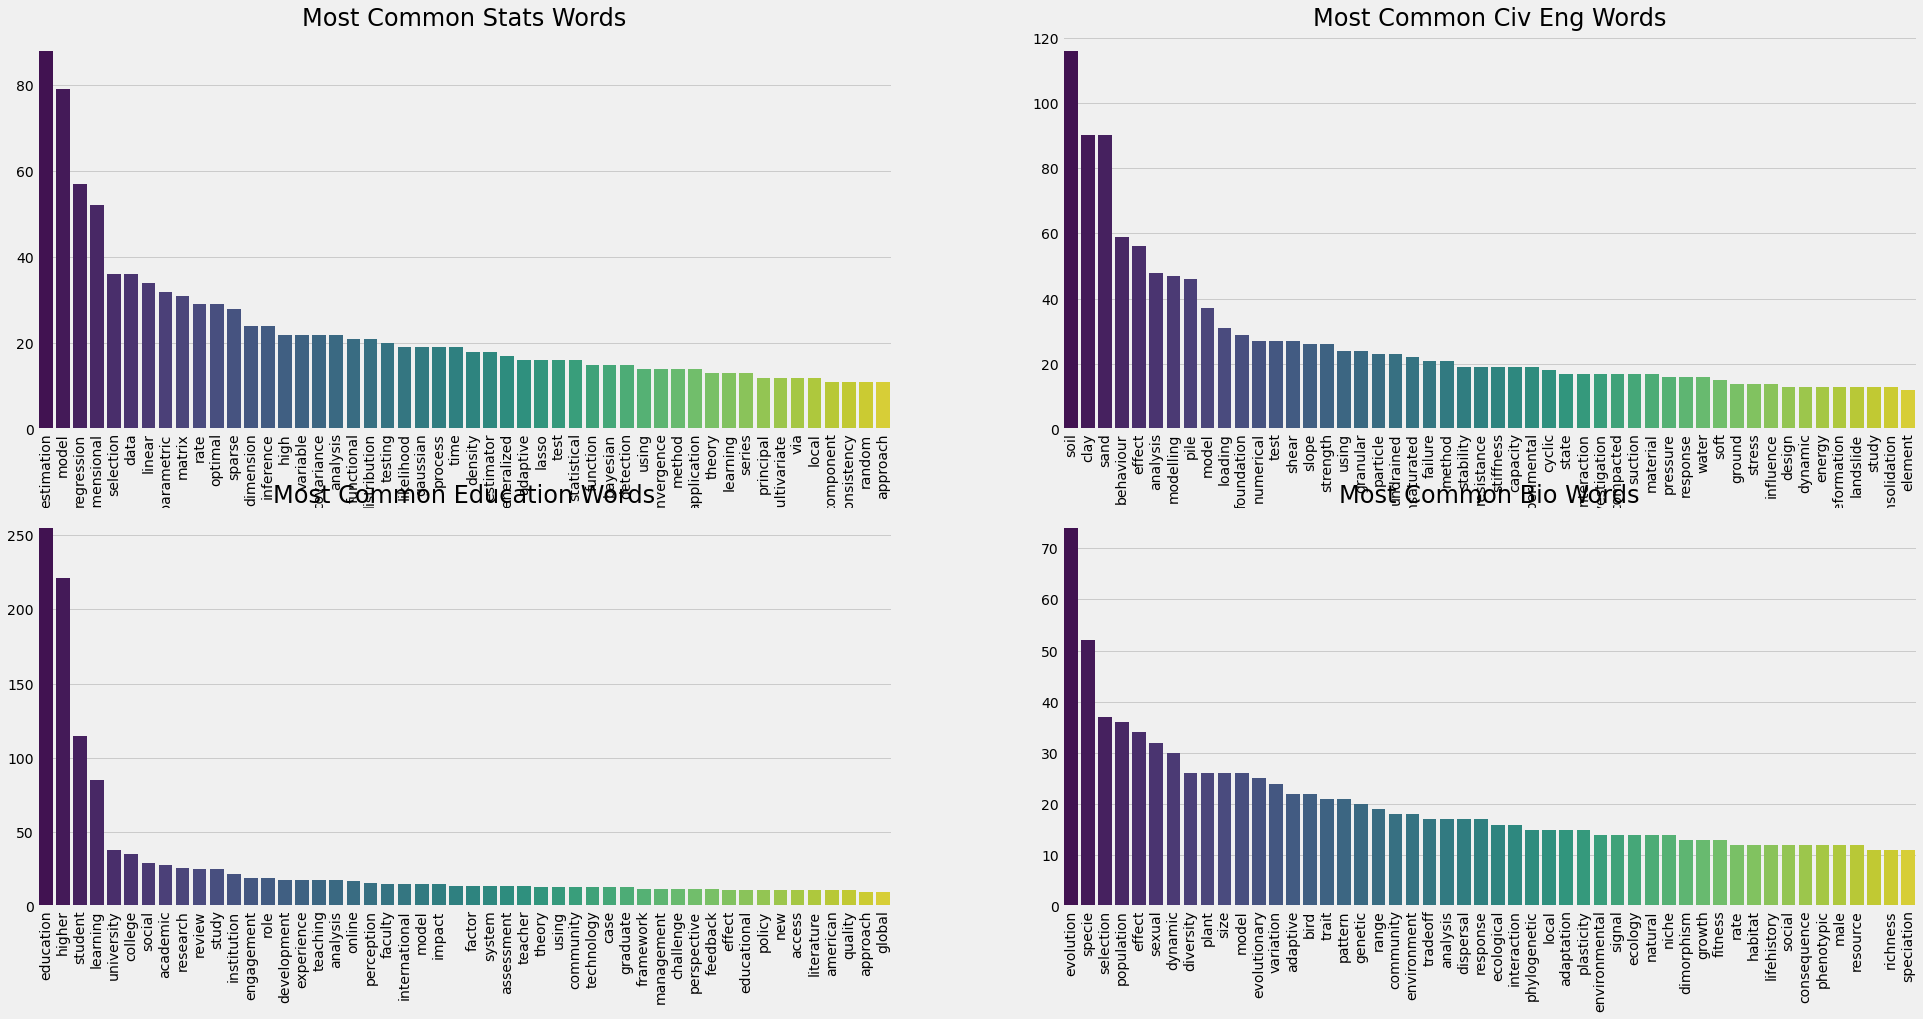

In [31]:
figure, axis = plt.subplots(2, 2, figsize = (30, 15))

# Plot bar graph of most commonly appearing words for given category
sns.barplot(x = stats_keys, y = stats_values, palette = 'viridis', ax = axis[0, 0])
axis[0, 0].set_xticklabels(stats_keys, rotation = 90)
#x.set_ylabel("# of Appearances", labelpad = 25)
axis[0, 0].set_title("Most Common Stats Words")

sns.barplot(x = civeng_keys, y = civeng_values, palette = 'viridis', ax = axis[0, 1])
axis[0, 1].set_xticklabels(civeng_keys, rotation = 90)
axis[0, 1].set_title("Most Common Civ Eng Words")

sns.barplot(x = educ_keys, y = educ_values, palette = 'viridis', ax = axis[1, 0])
axis[1, 0].set_xticklabels(educ_keys, rotation = 90)
axis[1, 0].set_title("Most Common Education Words")

sns.barplot(x = bio_keys, y = bio_values, palette = 'viridis', ax = axis[1, 1])
axis[1, 1].set_xticklabels(bio_keys, rotation = 90)
axis[1, 1].set_title("Most Common Bio Words");

Side note: Zipf's law!

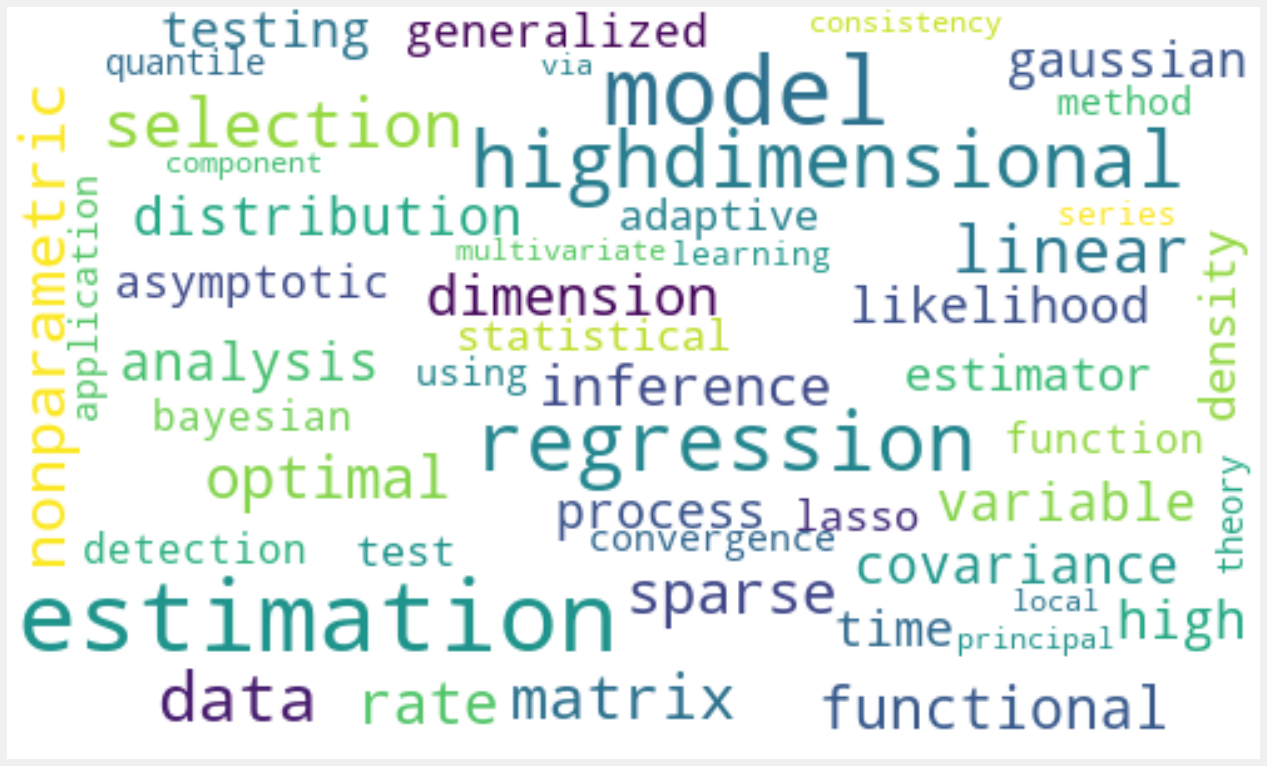

In [32]:
fig, ax = plt.subplots(figsize = (20, 20))

# Create and generate a word cloud image:
text = " ".join(word for word in all_stats_words)

wordcloud = WordCloud(max_font_size = 40, max_words = 50, background_color = "white", width = 500, height = 300, collocations = False).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

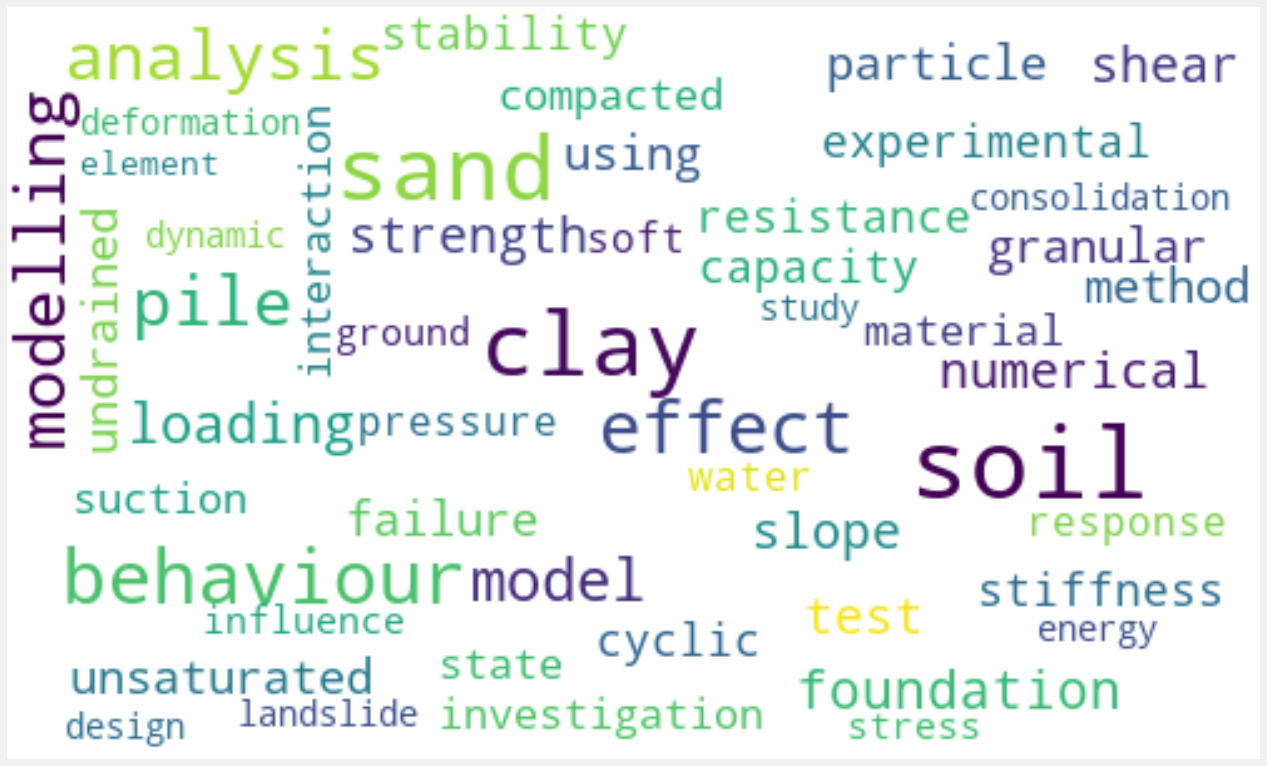

In [33]:
fig, ax = plt.subplots(figsize = (20, 20))

# Create and generate a word cloud image:
text = " ".join(word for word in all_civeng_words)

wordcloud = WordCloud(max_font_size = 40, max_words = 50, background_color = "white", width = 500, height = 300, collocations = False).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Train-Test Split

In [34]:
X = df[['Title', 'Lemmatized', 'Stemmed']]
Y = df['Category']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [35]:
X_train.head()

,Title,Lemmatized,Stemmed
1062,Bio-cementation of sandy soil using microbiall...,"[biocementation, sandy, soil, using, microbial...","[biocement, sandi, soil, use, microbi, induc, ..."
1556,When competition does not matter: grassland di...,"[competition, matter, grassland, diversity, co...","[competit, matter, grassland, divers, commun, ..."
855,Making sense of MOOCs: Musings in a maze of my...,"[making, sense, moocs, musing, maze, myth, par...","[make, sens, mooc, muse, maze, myth, paradox, ..."
284,Factor modeling for high-dimensional time seri...,"[factor, modeling, highdimensional, time, seri...","[factor, model, highdimension, time, seri, inf..."
1891,"When to care for, abandon, or eat your offspri...","[care, abandon, eat, offspring, evolution, par...","[care, abandon, eat, offspr, evolut, parent, c..."


In [36]:
X_train.shape

(1341, 3)

In [37]:
Y_train.head()

1062    Civil Engineering
1556              Biology
855             Education
284            Statistics
1891              Biology
Name: Category, dtype: object

In [38]:
Y_train.shape

(1341,)

# Feature Extraction

## Count Vectorization

In [39]:
# Function we will use when vectorizing; covers all previous cleaning steps (except lemmatization)
def preprocess(text):
    text_lc = ''.join([word.lower() for word in text if word not in string.punctuation]) # make lowercase and remove puntuation
    text_rc = re.sub(r'\d+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text_cleaned = [stemmer.stem(word) for word in tokens if word not in stop_words]  # remove stopwords and stemming
    return text_cleaned

In [40]:
#countVectorizer_train = CountVectorizer(analyzer = preprocess) 
#countVectorizer_test = CountVectorizer(analyzer = preprocess) 
countVectorizer = CountVectorizer(analyzer = preprocess) 

countVectorizer.fit(df['Title'])######################################################################

text_vect_train = countVectorizer.transform(X_train['Title'])
text_vect_test = countVectorizer.transform(X_test['Title'])

text_vect = countVectorizer.transform(df['Title'])

print("In the dataset overall, we have {} paper titles with {} (unique) words in total".format(text_vect.shape[0], text_vect.shape[1]))

In the dataset overall, we have 1917 paper titles with 3270 (unique) words in total


In [41]:
# Create dataframes (both train and test) of vectorized text
vect_train = pd.DataFrame(text_vect_train.toarray(), columns = countVectorizer.get_feature_names())
vect_test = pd.DataFrame(text_vect_test.toarray(), columns = countVectorizer.get_feature_names())
vect_train.head()

,,abandon,abil,abnorm,abras,abroad,absolut,abstract,abund,abut,...,μct,в,исследований,образования,ℓ,ℓnorm,ℓpenal,ℓregular,全面深化专业综合改革,略论应用型本科院校的定位
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF

I think TF-IDF is better than count vectorization above? Only need to choose one 
(We do need to use the count version to find likelihoods for Bayes though...)

In [42]:
vectorizer = TfidfVectorizer()

corpus = X_train['Lemmatized'].iloc[0]
print(corpus)
X = vectorizer.fit_transform(corpus)
#vectorizer.get_feature_names_out()
print(X)

['biocementation', 'sandy', 'soil', 'using', 'microbially', 'induced', 'carbonate', 'precipitation', 'marine', 'environment']
  (0, 0)	1.0
  (1, 7)	1.0
  (2, 8)	1.0
  (3, 9)	1.0
  (4, 5)	1.0
  (5, 3)	1.0
  (6, 1)	1.0
  (7, 6)	1.0
  (8, 4)	1.0
  (9, 2)	1.0


## Bag of Words for Each Category

In this section, get corpus of unique words for each category - we will need to use these later for modeling (+ plotting?)

In [43]:
# Split vect_df_train into 4 dfs, one for each category we have
vect_stats = vect_train.loc[np.array(Y_train == 'Statistics'), :]
# Repeat for other categories
vect_civeng = vect_train.loc[np.array(Y_train == 'Civil Engineering'), :]
vect_educ = vect_train.loc[np.array(Y_train == 'Education'), :]
vect_bio = vect_train.loc[np.array(Y_train == 'Biology'), :]

In [44]:
# Repeat the above for vect_df_test? (Do we need these?)


In [45]:
print("In the training set, we have {} statistics papers with {} unique words in total.".format(vect_stats.shape[0], vect_stats.loc[:, vect_stats.any(0)].shape[1]))
print("In the training set, we have {} civil engineering papers with {} unique words in total.".format(vect_civeng.shape[0], vect_civeng.loc[:, vect_civeng.any(0)].shape[1]))
print("In the training set, we have {} education papers with {} unique words in total.".format(vect_educ.shape[0], vect_educ.loc[:, vect_educ.any(0)].shape[1]))
print("In the training set, we have {} biology papers with {} unique words in total.".format(vect_bio.shape[0], vect_bio.loc[:, vect_bio.any(0)].shape[1]))

In the training set, we have 312 statistics papers with 635 unique words in total.
In the training set, we have 361 civil engineering papers with 829 unique words in total.
In the training set, we have 320 education papers with 909 unique words in total.
In the training set, we have 348 biology papers with 1116 unique words in total.


In [46]:
# Only care about words appearing in each category 
# (e.g. "eigenvalue" is not in the education set so we dont need P("eigenvlaue"|Education)
# Get a collection of words for each category (in list form)

corpus_stats = vect_stats.columns.values
corpus_civeng = vect_civeng.columns.values
corpus_educ = vect_educ.columns.values
corpus_bio = vect_bio.columns.values

print("For example, this is the set of (unique) words for stats: {}.".format(corpus_stats))

For example, this is the set of (unique) words for stats: ['' 'abandon' 'abil' ... 'ℓregular' '全面深化专业综合改革' '略论应用型本科院校的定位'].


# Classification

## Naive Bayes Classifier

To do naive Bayes, we need a few ingredients to find the desired posterior:
- prior probability: probability of any given title being in a category, e.g. 25% of papers in stats --> 0.25 prior of being classified as stats
- likelihoods: probabilities of individual words, given a category, e.g. P('model'|stats)

In [47]:
# Find priors
prior_sta = (Y_train == 'Statistics').sum() / Y_train.shape[0]
prior_cie = (Y_train == 'Civil Engineering').sum() / Y_train.shape[0]
prior_edu = (Y_train == 'Education').sum() / Y_train.shape[0]
prior_bio = (Y_train == 'Biology').sum() / Y_train.shape[0]

In [48]:
# Check 
prior_sta + prior_cie + prior_edu + prior_bio

1.0

In [49]:
# Store prior probabilities in convenient df
priors = pd.DataFrame([prior_sta, prior_cie, prior_edu, prior_bio]).transpose()
categories = ['Statistics', 'Civil Engineering', 'Education', 'Biology']
priors.columns = categories
priors

,Statistics,Civil Engineering,Education,Biology
0,0.232662,0.269202,0.238628,0.259508


In [50]:
def find_likelihood(word, category):
    """
    Takes as inputs: 
    word = which word we want the conditional probability for; 
    df = the dataframe of counts we will use (e.g. vect_stats)
    """
    # Follow procedure as before, getting the (subset of the) vectorized df for only 1 category
    category_df = vect_train.loc[np.array(Y_train == category), :]

    n = category_df.shape[0] 
    
    return (category_df[word].sum()+1) / (n+1)
    

In [51]:
find_likelihood(''.join(preprocess('statistical')), 'Statistics')

0.05750798722044728

In [52]:
# Find word frequencies in each category using training set - these will be the likelihoods when doing naive bayes
# +1 to assume every word appears in every category...
freq_stats = pd.DataFrame((vect_stats.sum(axis = 0)+1) / vect_stats.shape[0]).transpose()
freq_civeng = pd.DataFrame((vect_civeng.sum(axis = 0)+1) / vect_civeng.shape[0]).transpose()
freq_educ = pd.DataFrame((vect_educ.sum(axis = 0)+1) / vect_educ.shape[0]).transpose()
freq_bio = pd.DataFrame((vect_bio.sum(axis = 0)+1) / vect_bio.shape[0]).transpose()

freq_final = pd.concat([freq_stats, freq_civeng, freq_educ, freq_bio], ignore_index = True)
freq_final.rename(index = {0:'Statistics', 1:'Civil Engineering', 2:'Education', 3:'Biology'}, inplace=True)

In [53]:
freq_final

,,abandon,abil,abnorm,abras,abroad,absolut,abstract,abund,abut,...,μct,в,исследований,образования,ℓ,ℓnorm,ℓpenal,ℓregular,全面深化专业综合改革,略论应用型本科院校的定位
Statistics,0.006410,0.003205,0.003205,0.003205,0.003205,0.003205,0.006410,0.003205,0.003205,0.003205,...,0.003205,0.003205,0.003205,0.003205,0.006410,0.003205,0.006410,0.006410,0.003205,0.003205
Civil Engineering,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.005540,...,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770
Education,0.037500,0.003125,0.006250,0.003125,0.003125,0.006250,0.003125,0.006250,0.003125,0.003125,...,0.003125,0.006250,0.006250,0.006250,0.003125,0.003125,0.003125,0.003125,0.006250,0.006250
Biology,0.025862,0.005747,0.005747,0.002874,0.002874,0.002874,0.005747,0.002874,0.011494,0.002874,...,0.002874,0.002874,0.002874,0.002874,0.002874,0.002874,0.002874,0.002874,0.002874,0.002874


In [54]:
# Example of likelihoods for a word
freq_final['statist']

Statistics           0.057692
Civil Engineering    0.008310
Education            0.009375
Biology              0.017241
Name: statist, dtype: float64

In [55]:
def naive_bayes(title, categories):
    """
    Takes as inputs a title and a category we want to find the posterior for (both string inputs)
    - Make sure to use proper name of category
    Finds a single probability, denoting the posterior probability, i.e. P(title|category)
    Gives as output a table/dataframe storing the posteriors for every category so we can compare values easily
    """
    # Initialize empty df to fill and return later
    df = pd.DataFrame(np.zeros((1, len(categories))), columns = categories)
    
    # Preprocess title to get list of words to check
    words = preprocess(title)
    
    # We want to find the posterior for every category - loop through list of category names
    for cat in categories:
        # Find (product of) likelihoods of the words found in the title (or sum of log probabs?)
        likelihood_product = 0
        for word in words:
            if word in freq_final.columns.values:
                likelihood_product += log(freq_final.loc[cat, word])
        # Multiply by prior (found earlier) to get posterior  
        df[cat] = log(priors[cat]) + likelihood_product
 
    return df

In [56]:
def nb_classifier(X, Y, categories):
    """
    Decides which category to assign to a given paper title
    Then, checks against true class label...
    """
    n = X.shape[0]
    n_correct = 0
    for i, paper in X.iterrows():
        posteriors = naive_bayes(paper['Title'], categories)
        choice = posteriors.idxmax(axis=1)
        if choice.values == Y.loc[i]:
            n_correct += 1
            
    return n_correct / n

In [57]:
nb_classifier(X_test, Y_test, categories)

0.9583333333333334

Consistently getting ~95%

In [58]:
# sklearn implementation:

# fit the training dataset on the NB classifier
#Naive = naive_bayes.MultinomialNB()
#Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
#predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
#print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

In [59]:
gnb = GaussianNB()
y_pred = gnb.fit(vect_train, Y_train).predict(vect_test)
print("Number of mislabeled points out of a total %d points : %d"
% (text_vect_test.shape[0], (Y_test != y_pred).sum()))

Number of mislabeled points out of a total 576 points : 39


## Support Vector Machine

Recall we had these count vectorized dfs: 

In [60]:
vect_train.head()

,,abandon,abil,abnorm,abras,abroad,absolut,abstract,abund,abut,...,μct,в,исследований,образования,ℓ,ℓnorm,ℓpenal,ℓregular,全面深化专业综合改革,略论应用型本科院校的定位
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
vect_test.head()

,,abandon,abil,abnorm,abras,abroad,absolut,abstract,abund,abut,...,μct,в,исследований,образования,ℓ,ℓnorm,ℓpenal,ℓregular,全面深化专业综合改革,略论应用型本科院校的定位
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# SVM form sklearn

# Fit the classifier on the training dataset
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(vect_train, Y_train)

# Predict the labels on the test dataset
predictions_SVM = SVM.predict(vect_test)

In [63]:
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Y_test))

SVM Accuracy Score ->  0.9253472222222222


NOTES FOR MEETING:

- Hyphenated words currently get changed to one word because the - is just taken out, may want to make 2 words instead of 1, e.g. "varying coefficients" or "l-norm"
- Could take out/not consider words whose frequency falls below a certain threshold, e.g. people's names do not really give us any information
- **IF A WORD IS NOT IN A SET, THEN WE ARE ASSIGNING AN ARBITRARILY SMALL LIKELIHOOD; E.G. P('plankton"|Education)**
    - Do we just need a ton of data so the word frequencies are not so sparse
    - Or change categories so probab. of no-show words goes down? E.g. focus on sciences OR stats vs maths vs computer science --> surely then, we wouldn't have this sparseness issue
    - Bottom line: need different categories/groups to be more similar to one another for this task to be noteworthy enough; i.e. we don't want to be classifying things that are obvious...
- **What to do when word in test set does not appear in training set?**
- What to do about words in other languages/other "scripts" (like math symbols)?